### Load API_KEYS, Merge and Preprocess Datasets

In [21]:
 
import os
from dotenv import load_dotenv
import openai
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json
import matplotlib.pyplot as plt

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')


openai.api_key = openai_api_key

In [22]:
import pandas as pd

azure_marketplace = pd.read_csv('./Data/Azure marketplace growth.csv')
aws_marketplace = pd.read_csv('./Data/Aws marketplace growth.csv')
chatgpt_store_growth = pd.read_csv('./Data/ChatGPT Store growth.csv')
github_marketplace = pd.read_csv('./Data/Github marketplace growth.csv')
github_repo_stars_growth = pd.read_csv('./Data/Github repo stars growth.csv')
google_workspace_marketplace = pd.read_csv('./Data/Google Workspace Marketplace.csv')
salesforce_marketplace = pd.read_csv('./Data/Salesforce Marketplace growth.csv')
shopify_marketplace = pd.read_csv('./Data/Shopify marketplace growth.csv')
visual_studio_marketplace = pd.read_csv('./Data/Visual Studio Marketplace Growth.csv')








In [23]:
datasets = [
    azure_marketplace, aws_marketplace, chatgpt_store_growth, github_marketplace, 
    github_repo_stars_growth, google_workspace_marketplace, salesforce_marketplace, 
    shopify_marketplace, visual_studio_marketplace
]



In [24]:
unique_datasets = []
for dataset in datasets:
    if not any(dataset.equals(existing) for existing in unique_datasets):
        unique_datasets.append(dataset)

In [25]:
combined_data = pd.concat(unique_datasets, ignore_index=True)


cleaned_data = combined_data.drop_duplicates()


cleaned_data.to_csv("cleaned_marketplace_data.csv", index=False)



In [26]:


cleaned_data.fillna({
    'last_month_installs': 0,
    'this_month_installs': 0,
    'installs_m_m_growth': 0,
    'description': 'Unknown',
    'domain': 'Unknown',
    'last_month_stars': 0,
    'this_month_stars': 0,
    'stars_m_m_growth': 0,
}, inplace=True)

cleaned_data['name'] = cleaned_data['name'].str.strip()
cleaned_data['description'] = cleaned_data['description'].str.strip()
cleaned_data['domain'] = cleaned_data['domain'].str.strip()


cleaned_data.info()

output_path = "cleaned_marketplace_data.csv"
cleaned_data.to_csv(output_path, index=False)





<class 'pandas.core.frame.DataFrame'>
Index: 17757 entries, 0 to 17866
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 17757 non-null  object 
 1   url                  17355 non-null  object 
 2   last_month_installs  17757 non-null  float64
 3   this_month_installs  17757 non-null  float64
 4   installs_m_m_growth  17757 non-null  float64
 5   last_month_multiple  17740 non-null  float64
 6   description          17757 non-null  object 
 7   domain               17757 non-null  object 
 8   last_month_stars     17757 non-null  float64
 9   this_month_stars     17757 non-null  float64
 10  stars_m_m_growth     17757 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.6+ MB


/var/folders/7b/cj72_d7j6fz976klb3g42_ph0000gn/T/ipykernel_15936/846499854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.fillna({
/var/folders/7b/cj72_d7j6fz976klb3g42_ph0000gn/T/ipykernel_15936/846499854.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['name'] = cleaned_data['name'].str.strip()
/var/folders/7b/cj72_d7j6fz976klb3g42_ph0000gn/T/ipykernel_15936/846499854.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Perform Clustering 

In [47]:
def find_optimal_clusters(data, max_clusters=15):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(data['description'])
    
    inertia = []
    silhouette_scores = []
    
    for n in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
    return inertia, silhouette_scores


def plot_elbow_silhouette(inertia, silhouette_scores, max_clusters=15):
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters + 1), inertia, marker='o', label='Inertia')
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='x', label='Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia / Silhouette Score')
    plt.title('Elbow Method & Silhouette Score for Optimal Clusters')
    plt.legend()
    plt.show()


vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(cleaned_data['description'])


def perform_kmeans_clustering(data, X, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(X)
    return data


def normalize_growth_pace(cluster_data, base_value=100):
    """
    Normalize growth pace to express it in 'Xx growth' format using a base_value for scaling.
    """
    growth_pace = cluster_data['installs_m_m_growth'].mean()
    
    if growth_pace > 0:
        scaled_growth_pace = growth_pace / base_value
        normalized_growth_pace = f"{scaled_growth_pace:.2f}x growth"
    else:
        normalized_growth_pace = "No Growth"
    
    return normalized_growth_pace

def generate_trend_summary(cluster_data, model="gpt-4o-mini"):
    descriptions = " ".join(cluster_data['description'].tolist()[:10]) 
    messages = [
        {"role": "system", "content": "You are a helpful assistant that generates titles and descriptions for market trends."},
        {"role": "user", "content": f"Based on the following app descriptions, generate a title and description for this trend: {descriptions}"}
    ]
    
    response = openai.ChatCompletion.create(
        model=model,  
        messages=messages,
        max_tokens=500
    )
    
    return response['choices'][0]['message']['content']

def generate_trend_summaries(data):
    trend_summaries = []
    
    for cluster_id in data['cluster'].unique():
        cluster_data = data[data['cluster'] == cluster_id]
        summary = generate_trend_summary(cluster_data, model="gpt-4o-mini")
        growth_pace = normalize_growth_pace(cluster_data)
        
        trend_summaries.append({
            'cluster_id': cluster_id,
            'summary': summary,
            'growth_pace': growth_pace,
            'examples': cluster_data[['name', 'url']].head(7).to_dict(orient='records')
        })
    
    return trend_summaries

def save_trend_summaries(trend_summaries, output_file='trend_summaries.json'):
    def convert_np_types(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    with open(output_file, 'w') as f:
        json.dump(trend_summaries, f, indent=4, default=convert_np_types)

In [48]:
inertia, silhouette_scores = find_optimal_clusters(cleaned_data, max_clusters=15)

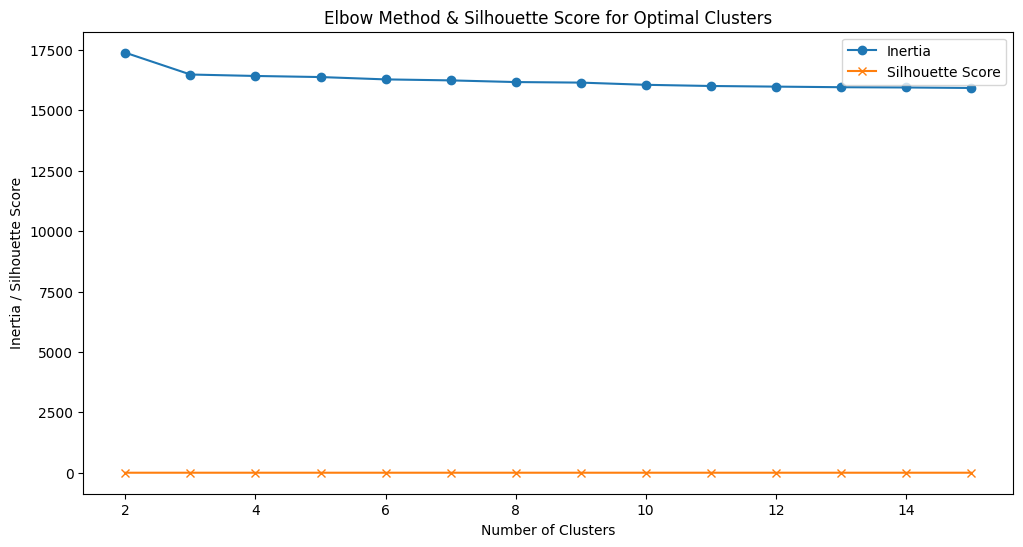

In [34]:
plot_elbow_silhouette(inertia, silhouette_scores)

In [49]:
n_clusters = 10  
clustered_data = perform_kmeans_clustering(cleaned_data, X, n_clusters)


/var/folders/7b/cj72_d7j6fz976klb3g42_ph0000gn/T/ipykernel_15936/508114792.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = kmeans.fit_predict(X)


### Generate Trend Summaries

In [50]:
trend_summaries = generate_trend_summaries(clustered_data)

In [51]:
save_trend_summaries(trend_summaries)

In [52]:

for trend in trend_summaries:
    print(f"Cluster {trend['cluster_id']} - Summary:\n{trend['summary']}")
    print(f"Growth Pace: {trend['growth_pace']}")
    print(f"Examples: {trend['examples']}")
    print("\n")

Cluster 3 - Summary:
**Title: "Rising Tide of Uncertainty in Consumer Trends"**

**Description:** In an era marked by unpredictability, the consumer landscape is witnessing an increase in the phenomenon known as "Unknown Unknowns." This trend highlights the challenges brands face as emerging behaviors and preferences remain largely undefined. As consumers navigate an ever-evolving marketplace, businesses must adapt their strategies to embrace the unknown, leveraging data analytics and market research to anticipate shifts in demand. By fostering innovation and flexibility, companies can position themselves to thrive amid uncertainty and uncover new opportunities that may arise from the unpredictable nature of consumer choice.
Growth Pace: 2.24x growth
Examples: [{'name': 'VMware Tanzu Greenplum (BYOL)', 'url': 'https://azuremarketplace.microsoft.com/en-us/marketplace/apps/pivotal.pivotal-greenplum-azure-byol?exp=ubp8&tab=Overview'}, {'name': 'Prefect 1', 'url': 'https://azuremarketplace